# Libraries and definitions

Sources:

* http://web.mit.edu/6.763/www/FT03/Lectures/Lecture12.pdf
* https://www.wmi.badw-muenchen.de/teaching/Lecturenotes/AS/AS2016_Chapter04_Slides.pdf
* https://www.wmi.badw.de/teaching/Lecturenotes/AS/AS_Chapter4.pdf

In [1]:
import numpy as np
from numpy import sin, cos, pi
from scipy.optimize import minimize

In [2]:
import matplotlib.pyplot as plt

In [3]:
from matplotlib import colors

In [4]:
Ic = 1
Phi0 = 1

In [5]:
def Is(phi1, Phi):
    return 2 * Ic * cos(pi * Phi / Phi0) * sin(phi1 + pi * Phi / Phi0)

def Phi_full(phi1, Phie, Phi, L):
    return Phie - L * Ic / 2 * sin(pi * Phi / Phi0) * cos(phi1 + pi * Phi / Phi0)

def objective(x):
    phi1 = x[0]
    Phi = x[1]
    return - Is(phi1, Phi)  # maximize due to minus sign

In [6]:
Phies = np.linspace(0,3,401)
Ls = np.array([0,0.5,1,2.5,5,20])
beta_Ls = 2*Ls*Ic/Phi0

# First real sim

In [7]:
phi1_sol = []
Phi_sol = []
for L in Ls:
    sols = []
    for i,Phie in enumerate(Phies):
        if i==0:
            x0=[0,0]
        else:
            x0=[sol.x[0],sol.x[1]]

        b1 = (-np.inf,np.inf)
        b2 = (-abs(Phie),abs(Phie))
        bnds= (b1,b2)

        def constraint1(x):
            phi1 = x[0]
            Phi = x[1]
            return Phi - Phi_full(phi1, Phie, Phi, L)

        con1 = {'type': 'ineq', 'fun': constraint1}
        cons = [con1]
        sol = minimize(objective,x0,constraints=cons,bounds=bnds)
        sols.append(sol.x)
        
    sols = np.array(sols)
    phi1_sol.append(sols[:,0])
    Phi_sol.append(sols[:,1])

phi1_sol = np.array(phi1_sol)
Phi_sol = np.array(Phi_sol)

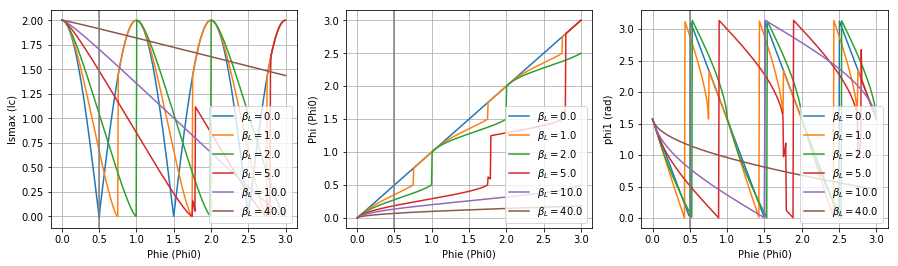

In [8]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))
plt.sca(ax1)
for bL,phi1,Phi in zip(beta_Ls,phi1_sol,Phi_sol):
    plt.plot(Phies,Is(phi1,Phi),label=r'$\beta_L={}$'.format(bL))
plt.legend(loc='lower right')
plt.axvline(0.5,c='grey')
plt.ylabel('Ismax (Ic)')
plt.grid()

plt.sca(ax2)
for bL,phi1,Phi in zip(beta_Ls,phi1_sol,Phi_sol):
    plt.plot(Phies,Phi,label=r'$\beta_L={}$'.format(bL))
plt.legend(loc='lower right')
plt.axvline(0.5,c='grey')
plt.ylabel('Phi (Phi0)')
plt.grid()

plt.sca(ax3)
for bL,phi1,Phi in zip(beta_Ls,phi1_sol,Phi_sol):
    plt.plot(Phies,phi1%pi,label=r'$\beta_L={}$'.format(bL))
plt.legend(loc='lower right')
plt.axvline(0.5,c='grey')
plt.ylabel('phi1 (rad)')
plt.grid()

for theax in [ax1,ax2,ax3]:
    plt.sca(theax)
    plt.xlabel('Phie (Phi0)')

The jumps in Ismax seem disturbing at first. However, this is exactly what we expect: As the loop inductance increases, the phase becomes hysteretic. So what we are seeing are the actual hysteretic Ics and Ljs! Still, this is not pretty to look at. What we usually see in DC measurements are the values down from 0 to 0.5 Phi0

# IVC-like sim

In [29]:
Phies = np.arange(0,0.5001,0.001)
phi1_sol = []
Phi_sol = []
for L in Ls:
    sols = []
    for i,Phie in enumerate(Phies):
        if i==0:
            x0=[0,0]
        else:
            x0=[sol.x[0],sol.x[1]]

        b1 = (-np.inf,np.inf)
        b2 = (-abs(Phie),abs(Phie))
        bnds= (b1,b2)

        def constraint1(x):
            phi1 = x[0]
            Phi = x[1]
            return Phi - Phi_full(phi1, Phie, Phi, L)

        con1 = {'type': 'ineq', 'fun': constraint1}
        cons = [con1]
        sol = minimize(objective,x0,constraints=cons,bounds=bnds)
        sols.append(sol.x)
        
    sols = np.array(sols)
    phi1_sol.append(sols[:,0])
    Phi_sol.append(sols[:,1])

phi1_sol = np.array(phi1_sol)
Phi_sol = np.array(Phi_sol)

In [30]:
fullPhie = np.concatenate(
    (
        Phies,Phies+Phies[-1],Phies+2*Phies[-1],Phies+3*Phies[-1],Phies+4*Phies[-1],Phies+5*Phies[-1]
    )
)
# fullphi1 = []
# fullPhi = []
fullIs = []

In [31]:
for phi1,Phi in zip(phi1_sol,Phi_sol):
    fullIs.append(
        np.concatenate(
            (
                Is(phi1,Phi),Is(phi1,Phi)[::-1],Is(phi1,Phi),Is(phi1,Phi)[::-1],Is(phi1,Phi),Is(phi1,Phi)[::-1]
            )
        )
    )

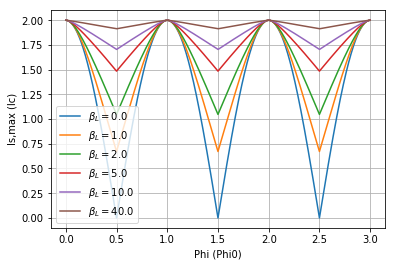

In [35]:
for fullI,bL in zip(fullIs,beta_Ls):
    plt.plot(fullPhie,fullI,label=r'$\beta_L={}$'.format(bL))
plt.legend()
plt.xlabel('Phi (Phi0)')
plt.ylabel('Is,max (Ic)')
plt.grid()

In [33]:
Ls

array([ 0. ,  0.5,  1. ,  2.5,  5. , 20. ])

In [34]:
LJs = 1/(2*pi*Ic)
Ls/LJs

array([  0.        ,   3.14159265,   6.28318531,  15.70796327,
        31.41592654, 125.66370614])

# 2D sim

In [119]:
Ls = np.linspace(0,101,101)
beta_Ls = 2*Ls*Ic/Phi0

In [120]:
Phies = np.arange(0,0.5001,0.001)
phi1_sol = []
Phi_sol = []
for L in Ls:
    sols = []
    for i,Phie in enumerate(Phies):
        if i==0:
            x0=[0,0]
        else:
            x0=[sol.x[0],sol.x[1]]

        b1 = (-np.inf,np.inf)
        b2 = (-abs(Phie),abs(Phie))
        bnds= (b1,b2)

        def constraint1(x):
            phi1 = x[0]
            Phi = x[1]
            return Phi - Phi_full(phi1, Phie, Phi, L)

        con1 = {'type': 'ineq', 'fun': constraint1}
        cons = [con1]
        sol = minimize(objective,x0,constraints=cons,bounds=bnds)
        sols.append(sol.x)
        
    sols = np.array(sols)
    phi1_sol.append(sols[:,0])
    Phi_sol.append(sols[:,1])

phi1_sol = np.array(phi1_sol)
Phi_sol = np.array(Phi_sol)

In [121]:
fullPhie = np.concatenate(
    (
        Phies,Phies+Phies[-1],Phies+2*Phies[-1],Phies+3*Phies[-1],Phies+4*Phies[-1],Phies+5*Phies[-1]
    )
)
fullIs = []

In [122]:
fullIs = np.array(
    [
        np.concatenate(
            (
                Is(phi1,Phi),Is(phi1,Phi)[::-1],Is(phi1,Phi),Is(phi1,Phi)[::-1],Is(phi1,Phi),Is(phi1,Phi)[::-1]
            )
        )
    for phi1,Phi in zip(phi1_sol,Phi_sol)
    ]
)

(-0.0999999999917139, 2.0999999998275474)

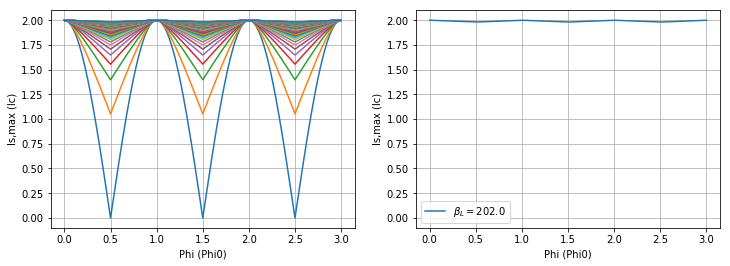

In [143]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
plt.sca(ax1)
for fullI,bL in zip(fullIs,beta_Ls):
    plt.plot(fullPhie,fullI,label=r'$\beta_L={}$'.format(bL))
#plt.legend()
plt.xlabel('Phi (Phi0)')
plt.ylabel('Is,max (Ic)')
plt.grid()
axlims = plt.gca().get_ylim()
plt.sca(ax2)
plt.plot(fullPhie,fullIs[-1],label=r'$\beta_L={}$'.format(beta_Ls[-1]))
plt.legend()
plt.xlabel('Phi (Phi0)')
plt.ylabel('Is,max (Ic)')
plt.grid()
plt.ylim(axlims)

In [124]:
X,Y = np.meshgrid(fullPhie,beta_Ls)
Z = np.array([fullI for fullI in fullIs])

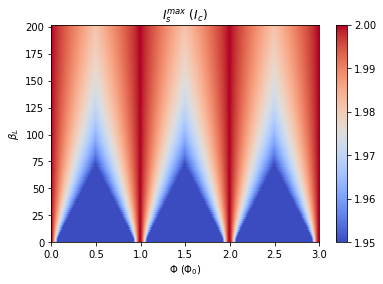

In [139]:
plt.pcolormesh(X,Y,Z,cmap='coolwarm',vmin=1.95,vmax=2)
plt.xlabel(r'$\Phi$ ($\Phi_0$)')
plt.ylabel(r'$\beta_L$')
plt.title(r'$I_s^{max}$ ($I_c$)')
plt.colorbar()
#plt.ylim(0,70)

# Asymmetry simulation